## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
import proplot as pplt
import warnings
warnings.filterwarnings('ignore')

## User-Defined Fields

In [2]:
path  = # '/directory/where/small/domain/files/are/located/'
cases = ['nz_32','nz_64','nz_128','nz_256']
start = 50  # calculate fields starting from this day
end   = 150 # calculate fields until this day
w_thresh  = 1    # updraft threshold (m/s)
cf_thresh = 5e-3 # cloud fraction mixing ratio threshold (g/kg)
qn_thresh = 0.1  # cloud ice and water mixing ratio threshold (g/kg)

## Calculate Time-Mean Variables

Calculate cloud fraction $CF$, where cloudiness is defined as the fractional area where $q_n$ > ```cf_thresh```. Calculate relative humidity $RH$, temperature difference $T$, and regular and clear-sky radiative heating rates ($Q_r$ and $Q_{r,clear}$, respectively).

In [3]:
cf  = []
rh  = []
T   = []
qrad  = []
qrad_clear = []
for i,case in enumerate(cases):
    ## Calculate Cloud Fraction
    qnfiles = np.sort(glob.glob(path+case+'/OUT_3D/QN/*.nc'))
    qn = xr.open_mfdataset(qnfiles).sel(time=slice(start,end)).QN
    nx = len(qn.x)
    ny = len(qn.y)
    ntime  = len(qn.time)
    cloudy = qn > cf_thresh 
    cf.append(cloudy.sum(dim=('x','y','time')).load()/(nx*ny*ntime))
    ## Calculate Time-Mean RH, T, and QRAD
    statfile = glob.glob(path+case+'/OUT_STAT/*.nc')[0]
    stats = xr.open_dataset(statfile).sel(time=slice(start,end))
    rh.append(stats.RELH.mean('time').load()/100)
    T.append((stats.TABS.mean('time').load()).interp(z=cf[-1].z))
    qrad.append(stats.RADQR.mean('time').load())
    qrad_clear.append(stats.RADQRS.mean('time').load())

Calculate the vertical gradient of the log of environmental saturation specific humidity following $\gamma$ = $-\partial_z\ln(q_{ve}^*)$. Use this to calculate the diagnostic steady-state fractional detrainment rate following Romps (2014) & Singh et al. (2019), which includes both condensate that evaporate and water vapor:

$$\delta_T = \frac{RH\gamma}{1-RH}$$

Calculate fractional updraft area $\sigma_{up}$, where updrafts are defined as $q_n$ > ```qn_thresh``` and $w$ > ```w_thresh```.Determine the mean updraft vertical velocity $w_{up}$. Use it to calculate the volumetric detrainment rate as $\delta_T w_{up}$, mean updraft mass flux $M_{up}$, and clould lifetime as $\tau = \frac{CF}{\delta_T\omega_{up}}$.

In [1]:
g  = 9.81
Lv = 2.5e6 
cp = 1005.7 
T_0n = 285
T_00n = 253.16

In [12]:
D = []
tau = []
M_up = []
D_time = []
for i,case in enumerate(cases):
    ## Calculate Gamma
    statfile = glob.glob(path+case+'/OUT_STAT/*.nc')[0]
    rsat  = (xr.open_dataset(statfile).QSAT).sel(time=slice(start,end)).mean('time').load()/1000 # from g/kg to kg/kg
    qsat  = rsat/(1+rsat)
    gamma = -(np.log(qsat)).differentiate('z')
    ## Calculate Fractional Detrainment Rate
    D.append(rh[i]*gamma/(1-rh[i]))
    ## Calculate Fractional Updraft Area
    qnfiles = np.sort(glob.glob(path+case+'/OUT_3D/QN/*.nc'))
    wfiles  = np.sort(glob.glob(path+case+'/OUT_3D/W/*.nc'))
    qn = xr.open_mfdataset(qnfiles).QN.sel(time=slice(start,end))
    w  = xr.open_mfdataset(wfiles).W.sel(time=slice(start,end))
    updraft = (qn > qn_thresh)&(w > w_thresh)
    nx = len(updraft.x)
    ny = len(updraft.y)
    ntime = len(updraft.time)
    sigma_up = updraft.sum(dim=('x','y','time'))/(nx*ny*ntime)
    ## Calculate Mean Updraft Vertical Velocity
    wup = sigma_up*xr.where(updraft,w,np.nan).mean(dim=('x','y','time')).load()
    ## Calculate Volumetric Detrainment Rate
    D_time.append(D[i]*wup)
    ## Calculate Mean Updraft Mass Flux
    Mfiles = np.sort(glob.glob(path+case+'/OUT_3D/massflux/*.nc'))
    M = xr.open_mfdataset(files).M.sel(time=slice(start,end))
    M_up.append(xr.where(updraft,M,np.nan).mean(dim=('x','y','time')).load()*sigma_up)
    ## Calculate Cloud Lifetime
    tau.append(cf[i]/D_time[i])

## Plot Fig. 2

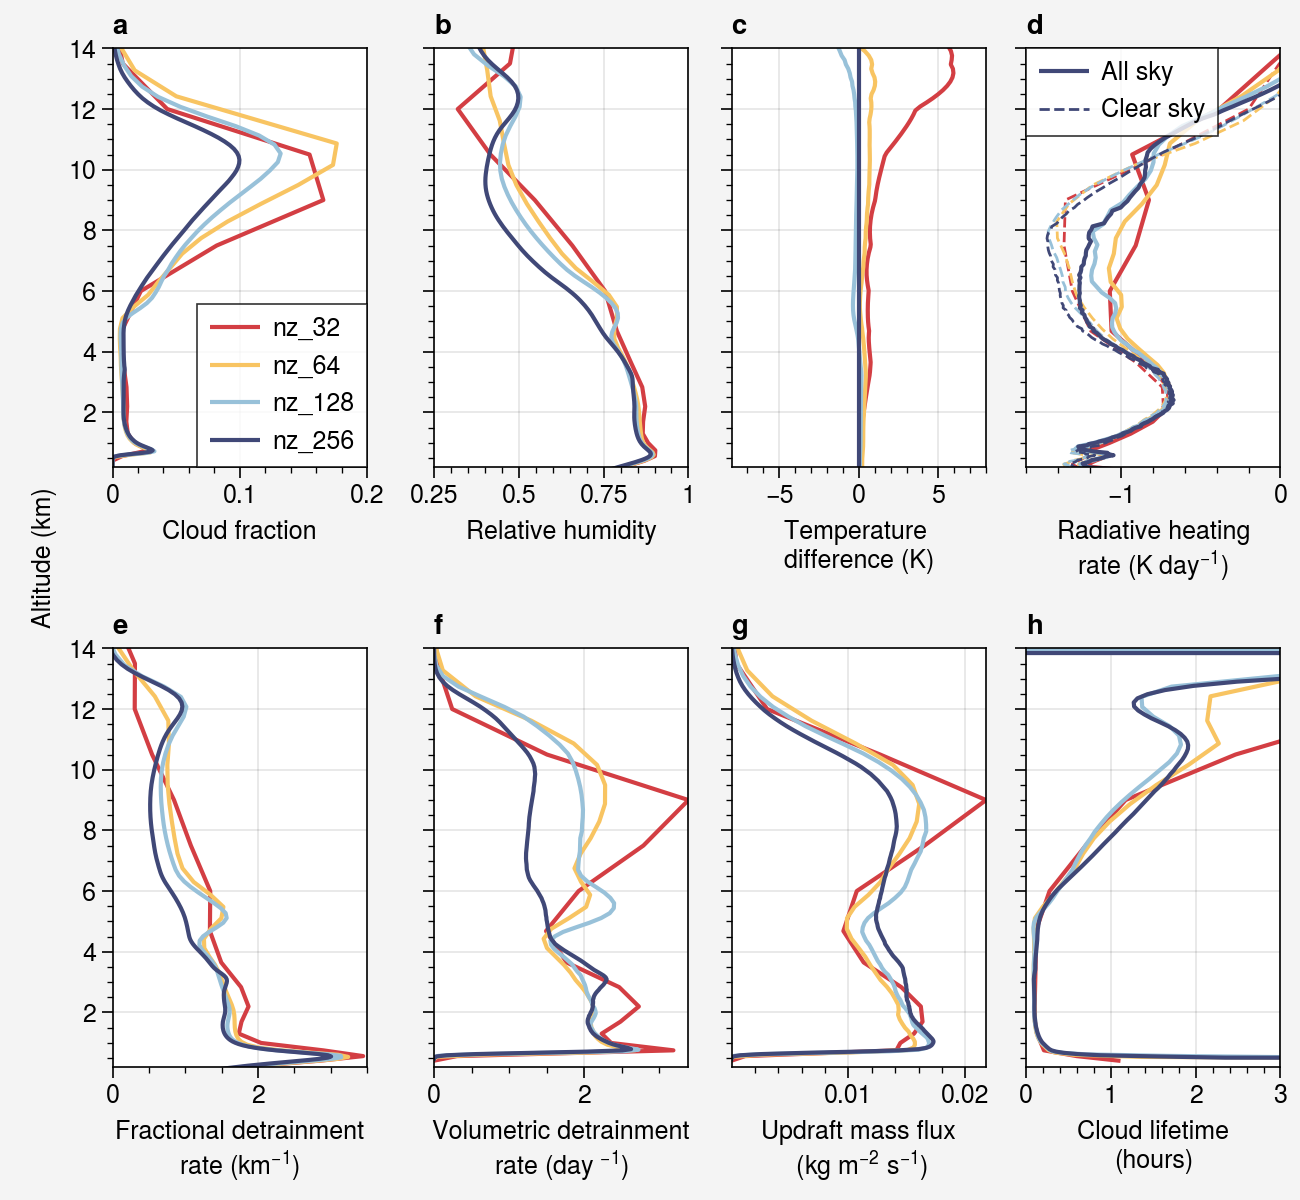

In [14]:
cmap    = np.asarray([[211,62,67,255],[248,196,98,255],[152,193,217,255],[64,72,119,255]])/255
fig,axs = pplt.subplots(nrows=2,ncols=4,sharex=0,sharey=3,width=6.5,height=6,left=4.5)
axs.format(abc=True,ylabel='Altitude (km)')  
axs[0].format(ylabel='Altitude (km)',xlabel='Cloud fraction',ylim=(0.2,14),xlim=(0,0.20))
axs[1].format(xlabel='Relative humidity',xlim=(.25,1.00))
axs[2].format(xlabel='Temperature \ndifference (K)',xlim=(-8,8))
axs[3].format(xlabel='Radiative heating\nrate (K day$^{-1}$)',xlim=(-1.6, 0))
axs[4].format(xlabel='Fractional detrainment\nrate (km$^{-1}$)',ylim=(0.2, 14),xlim=(0,3.5))
axs[5].format(xlabel='Volumetric detrainment\nrate (day $^{-1}$)')
axs[6].format(xlabel='Updraft mass flux\n (kg m$^{-2}$ s$^{-1}$)')
axs[7].format(xlabel='Cloud lifetime\n(hours)',xlim=(0,3))
for i,case in enumerate(cases):
    axs[0].plot(cf[i],cf[i].z/1000,color=cmap[i],label=case)
    axs[1].plot(rh[i],rh[i].z/1000,color=cmap[i])
    axs[2].plot(T[i]-T[-1],T[i].z/1000,color=cmap[i])
    h1 = axs[3].plot(qrad[i],qrad[i].z/1000,color=cmap[i],label='All sky')
    h2 = axs[3].plot(qrad_clear[i],qrad_clear[i].z/1000,color=cmap[i],linestyle='--',linewidth=1,label='Clear sky')
    axs[4].plot(1e3*D[i],D[i].z/1000,label=case,color=cmap[i])
    axs[5].plot(86400*D_time[i],D_time[i].z/1000,label=case,color=cmap[i])
    axs[6].plot(M_up[i],M_up[i].z/1000,label=case,color=cmap[i])
    axs[7].plot(tau[i]/3600,tau[i].z/1000,label=case,color=cmap[i])
axs[0].legend(ncols=1)
axs[3].legend([h1[0],h2[0]],ncols=1)